In [ ]:
import torch
from minai.core import *
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-09-18 19:50:11.124693: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-18 19:50:11.361383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the model

In [ ]:
# Load a model and tokenizer
model_id = 'meta-llama/Llama-2-7b-hf'
llama_base = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)
llama_base.gradient_checkpointing_enable()  # << Save memory
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Prepare the Data

In [ ]:
# Load a dataset
dataset = load_dataset("knowrohit07/know_sql", split="train")

# Create train and eval splits
dataset = dataset.shuffle()
train_dataset = dataset.select(range(0, 320)) # Subset for testing
eval_dataset = dataset.select(range(len(dataset)-200, len(dataset))) # And only 200 eval samples
train_dataset

Dataset({
    features: ['question', 'context', 'answer'],
    num_rows: 320
})

In [ ]:
# Create a text field in the datasets
def to_text(x):
    x['text'] = 'Context:\n' + x['context'] + '\nQuestion:' + x['question'] + '\nAnswer:' + x['answer']
    return x
train_dataset = train_dataset.map(to_text)
eval_dataset = eval_dataset.map(to_text)
eval_dataset

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'context', 'answer', 'text'],
    num_rows: 200
})

In [ ]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [ ]:
# Create DataLoaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([16, 133]), torch.Size([16, 133]))

In [ ]:
tokenizer.decode(xb[0])

'<s> Context:\nCREATE TABLE table_name_92 (athlete VARCHAR, date VARCHAR)\nQuestion:Date of 10 july 2009 includes what athlete?\nAnswer:SELECT athlete FROM table_name_92 WHERE date = "10 july 2009"</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [ ]:
tokenizer.decode(yb[0])

'Context:\nCREATE TABLE table_name_92 (athlete VARCHAR, date VARCHAR)\nQuestion:Date of 10 july 2009 includes what athlete?\nAnswer:SELECT athlete FROM table_name_92 WHERE date = "10 july 2009"</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

# Training

In [ ]:
# New model that wraps the original model, since the model
# produces an output object and we just want the logits:
class LLMWrapperModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, input_ids):
        logits = self.model(input_ids).logits
        return logits
model = LLMWrapperModel(llama_base)

In [ ]:
# Dataloaders 
dls = DataLoaders(train_dataloader, eval_dataloader)

# Specify LR
lr = 1e-4 

# Callbacks (just the standard minai ones for now)
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]

# Freeze the base model
for param in model.model.parameters():
    param.requires_grad = False

# Unfreeze final layer (lm_head_)
for param in model.model.lm_head.parameters():
    param.requires_grad = True

def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

# Create a learner
learn = Learner(model, dls, loss_func=loss_fn, lr=lr, cbs=cbs, opt_func=torch.optim.Adam)

In [ ]:
# learn.lr_find(max_mult=10)

loss,epoch,train
3.869,0,train
2.359,0,eval


/usr/lib/python3/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


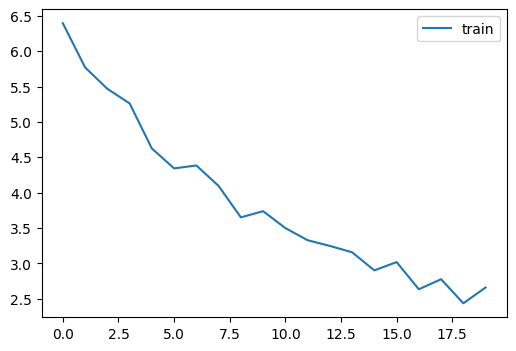

In [ ]:
# And fit
learn.fit(1)

# Testing

In [ ]:
prompt = "Context:" + eval_dataset[0]['context'] + "\nQuestion:" + eval_dataset[0]['question'] + "\nAnswer:"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
output = model.model.generate(tokenized_prompt, max_new_tokens=20)
print(prompt + tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True))

Context:CREATE TABLE table_name_45 (venue VARCHAR, attendance INTEGER)
Question:What venue has more than 50,715 attending?
Answer:SELECT venue FROM table_name_45 WHERE attendance > 50715
